In [1]:
# Install Java, Spark, and Findspark
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-us.apache.org/dist/spark/spark-2.4.7/spark-2.4.7-bin-hadoop2.7.tgz
!tar xf spark-2.4.7-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.7-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [2]:
# I have yelp 100k dataset loaded into my google drive
# this allows me to access that data from inside spark
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
# Start a SparkSession
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("word2vec").getOrCreate()

In [4]:
from pyspark.sql.types import StructType, StructField, StringType
from pyspark.ml.feature import Word2Vec
import string

schema = StructType([StructField("text", StringType(), True)])

In [15]:
# This URL is on my gdrive only! I loaded it there from a download from the internet
url = "/content/gdrive/MyDrive/covidvaccinedata_2021-03-13_v2_COUNTRY_UK.csv"
df = spark.read.schema(schema).csv(url, sep=",", header=False)

In [16]:
df.show(truncate=False)

+------------------------------------------------------------------------------------------------------------+
|text                                                                                                        |
+------------------------------------------------------------------------------------------------------------+
|TEXT_CLEANED                                                                                                |
|When I see  corona recovery is going better in here                                                         |
|covidinengl coronavirus engl CovidVaccine "                                                                 |
|Question has anyone successfully signed up My parents cant because  promised email link doesnt arrive Is it |
| You pay me 5000 cash tax free  Ill take  chanceas this my life you playing with  you can st                |
|CanSinoBIO lists successfully on STAR Market as Initial dual listing CovidVaccine China company             |
|

In [17]:
# punctuation removal due to relatively small datasize
def remove_punctuation(txt):
  return "".join(l if l not in string.punctuation else "" for l in txt)

In [18]:
from pyspark.sql.functions import col, udf

remove_punctuation_udf = udf(remove_punctuation, StringType())
remove_punctuation_udf

<function __main__.remove_punctuation>

In [19]:
df = df.withColumn("clean_text", remove_punctuation_udf(col("text")))
df.show()

+--------------------+--------------------+
|                text|          clean_text|
+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|
|When I see  coron...|When I see  coron...|
|covidinengl coron...|covidinengl coron...|
|Question has anyo...|Question has anyo...|
| You pay me 5000 ...| You pay me 5000 ...|
|CanSinoBIO lists ...|CanSinoBIO lists ...|
|China grants 1st ...|China grants 1st ...|
|China has granted...|China has granted...|
|Ive registered fo...|Ive registered fo...|
|Russias COVID19 v...|Russias COVID19 v...|
|The vaccine known...|The vaccine known...|
|Thx for  shout ou...|Thx for  shout ou...|
| Covid19 19 ways ...| Covid19 19 ways ...|
|      Love this guy |      Love this guy |
|   peace love  light|   peace love  light|
|vaccine CovidVacc...|vaccine CovidVacc...|
|                   "|                    |
|Bad news for Covi...|Bad news for Covi...|
|The new D614G mut...|The new D614G mut...|
|Grafitti has been...|Grafitti h

In [20]:
# pandas dataframe to measure length
df_new = df.toPandas()
len(df_new)

29859

In [21]:
from pyspark.sql.functions import length
length(df.text)

Column<b'length(text)'>

In [22]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline

# "Creating pipeline..."
tokenizer = Tokenizer(inputCol="clean_text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text', outputCol='features')

pipeline = Pipeline(stages=[tokenizer, stopremove])

# "Training model..."
pipeline_stg = pipeline.fit(df)
final_df = pipeline_stg.transform(df)
final_df.show()

+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|
+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|
|When I see  coron...|When I see  coron...|[when, i, see, , ...|[see, , corona, r...|
|covidinengl coron...|covidinengl coron...|[covidinengl, cor...|[covidinengl, cor...|
|Question has anyo...|Question has anyo...|[question, has, a...|[question, anyone...|
| You pay me 5000 ...| You pay me 5000 ...|[, you, pay, me, ...|[, pay, 5000, cas...|
|CanSinoBIO lists ...|CanSinoBIO lists ...|[cansinobio, list...|[cansinobio, list...|
|China grants 1st ...|China grants 1st ...|[china, grants, 1...|[china, grants, 1...|
|China has granted...|China has granted...|[china, has, gran...|[china, granted, ...|
|Ive registered fo...|Ive registered fo...|[ive, regis

In [23]:
# in class I had used vectorsize of 200 and max iterations of 2
word2vec = Word2Vec(
    vectorSize=200,
    seed=42,
    inputCol="features",
    outputCol="model"
).setMaxIter(3)
model = word2vec.fit(final_df)

In [24]:
model.getVectors().show(truncate=False)

+----------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
vecs = model.getVectors()

In [26]:
vecs.filter(vecs["word"] == "incident").show()

+----+------+
|word|vector|
+----+------+
+----+------+



In [27]:
# TEST WORDS HERE
model.findSynonymsArray("shot", 20)

[('mums', 0.754544734954834),
 ('injection', 0.7424962520599365),
 ('bror', 0.7112544178962708),
 ('monday', 0.7013720870018005),
 ('dads', 0.6852917671203613),
 ('booked', 0.6844086050987244),
 ('27th', 0.6841026544570923),
 ('ivf', 0.6804598569869995),
 ('500k', 0.676254391670227),
 ('yay', 0.6723440885543823),
 ('thursday', 0.6696491837501526),
 ('keepsafe', 0.6635757684707642),
 ('saturday', 0.6599825620651245),
 ('post', 0.6594939827919006),
 ('friday', 0.6568645238876343),
 ('az', 0.6542597413063049),
 ('sore', 0.6522928476333618),
 ('tender', 0.6433427929878235),
 ('aches', 0.6426613926887512),
 ('400', 0.6377373337745667)]

In [28]:
w2v = model.transform(final_df)

In [29]:
w2v.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|          clean_text|          token_text|            features|               model|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|        TEXT_CLEANED|         TEXTCLEANED|       [textcleaned]|       [textcleaned]|[0.0,0.0,0.0,0.0,...|
|When I see  coron...|When I see  coron...|[when, i, see, , ...|[see, , corona, r...|[-0.0035641730452...|
|covidinengl coron...|covidinengl coron...|[covidinengl, cor...|[covidinengl, cor...|[0.02679573092609...|
|Question has anyo...|Question has anyo...|[question, has, a...|[question, anyone...|[0.01066080220819...|
| You pay me 5000 ...| You pay me 5000 ...|[, you, pay, me, ...|[, pay, 5000, cas...|[0.05044691500564...|
|CanSinoBIO lists ...|CanSinoBIO lists ...|[cansinobio, list...|[cansinobio, list...|[-0.0012736999091...|
|China grants 1st ...|China grants 1s

In [30]:
w2v_clustering = w2v.select(
    "text", "model"
).withColumnRenamed("model", "features")

In [31]:
w2v_clustering.show(truncate=False)

+------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [32]:
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=10, inputCol="features", outputCol="pcaFeatures")
PCAmodel = pca.fit(w2v_clustering)
result = PCAmodel.transform(w2v_clustering)
result.show(truncate=False)

+------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [33]:
result = result.select("text", "pcaFeatures")
w2v_clustering = result.withColumnRenamed("pcaFeatures", "features")
w2v_clustering.show(truncate=False)

+------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                        |features                                                                                                                                                                                                           |
+------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|TEXT_CLEANED                  

In [34]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Trains a k-means model. < TRY NEW GROUP NUMBERS HERE 
kmeans = KMeans().setK(9).setSeed(1)
km_model = kmeans.fit(w2v_clustering)

In [35]:
# Make predictions
predictions = km_model.transform(w2v_clustering)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator(distanceMeasure="cosine")

# TEST YOUR FIT
# silhouette score goes between -1, 1. 1 is better. Negative is bad
silhouette = evaluator.evaluate(predictions)
print("Silhouette with cosine distance = " + str(silhouette))

Silhouette with cosine distance = 0.13306800700995386


In [36]:
# AGP INSERT >> FIND BEST CLUSTER Size? ["Elbow Method"]
import numpy as np
import pandas as pd

# Calculate clusterSize and plot
clusterSize = np.zeros(15)

for k in range(2,15):
    # Trains a k-means model.
    kmeans = KMeans().setK(k).setSeed(1)
    km_model = kmeans.fit(w2v_clustering)
    predictions = km_model.transform(w2v_clustering)
    evaluator = ClusteringEvaluator(distanceMeasure="cosine")
    clusterSize[k] = evaluator.evaluate(predictions)

# Define the dataframe of cosines
df_clusterSize = pd.DataFrame(clusterSize[2:])
df_clusterSize.columns = ["cosine"]
new_col = [2,3,4,5,6,7,8,9,10,11,12,13,14]
df_clusterSize.insert(0, 'cluster', new_col)

df_clusterSize

,cluster,cosine
0,2,0.000000
1,3,0.029250
2,4,0.205887
3,5,0.170006
4,6,0.092847
5,7,0.164436
6,8,0.132266
7,9,0.133068
8,10,0.142135
9,11,0.218760


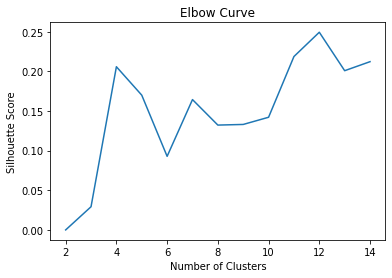

In [37]:
# PLOT the cosines

import pylab as pl
pl.plot(df_clusterSize.cluster, df_clusterSize.cosine)
pl.xlabel('Number of Clusters')
pl.ylabel('Silhouette Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
predictions.show()

+--------------------+--------------------+----------+
|                text|            features|prediction|
+--------------------+--------------------+----------+
|        TEXT_CLEANED|[0.0,0.0,0.0,0.0,...|         7|
|Al Gore Didnt he ...|[-0.0599538410468...|         8|
|ClimateChange aka...|[0.0,0.0,0.0,0.0,...|         7|
|Belgian newspaper...|[0.05067667245965...|         8|
|Covid Vaccine Tri...|[0.25735706780703...|         2|
|covid vaccine imm...|[0.39020194973401...|         3|
|Covid19 vaccine c...|[0.24317832544220...|         4|
|Presented by Dr A...|[6.53984630036426...|         7|
|56 are in Phase I...|[0.04490243430432...|         8|
|A list of who sho...|[-0.0495259951342...|         0|
|Im talking  some ...|[-0.0776420937737...|         0|
|You know what I d...|[-0.0608359925809...|         0|
| Yes  key thread was|[-0.1448855019964...|         0|
|1 should GPs deli...|[0.12755208585296...|         8|
|2 how can this be...|[-5.6977906877236...|         8|
|         

In [ ]:
predictions.filter("prediction=6").show(50, truncate=False)

+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|text                                               |features                                                                                                                                                                                                           |prediction|
+---------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|AstraZeneca CovidVaccine QuickTake                 |[-0.5042872232435108,-0.4244550587161168,-0.09282570179091675,0.09685284144724195,0.04865785002721759,7.357510826703